In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *
from functions.helpers import organise_data, prcnt_hft_trading, all_sharpe, sharpe

# Benchmark scenario
To start to get a feel for the model dynamics, I start with a simple benchmark scenario with a single HFM $N_{h} = 1$ and , where the fundamental is stationary $\sigma^f = 0$, and where there are no chartist LFTs $\sigma^{wc} = 0$.

In [66]:
NRUNS = 5

In [67]:
# 1 setup parameters
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 1,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 1,
    "fundamental_value": 10,
    "std_fundamental": 0.0,
    "lft_sample_size": 0.03,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 1,
    "std_HFT_vol": 4,
    "max_order_expiration_ticks": 30,
    "transaction_fee": 0.0,
    "max_spread_exchange": 0.01,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 0.0, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 10,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 0.01,
    "hfm_adaptive_param": 0.2,
    "hfm_volatility_sensitivity": 1.9,
    # initial values
    "horizon_min": 1,
    "horizon_max": 9,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 5,
    "total_hft_money": 250,
    "hft_speed": 1,
}

## 1 Baseline simulations

In [68]:
hfms = []
lfts = []
obs = []
for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
    print('seed is ', seed)
    high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
    hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
    hfms.append(hft)
    lfts.append(lft)
    obs.append(ob)

seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750


In [69]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

### a Prices, Returns & Volume

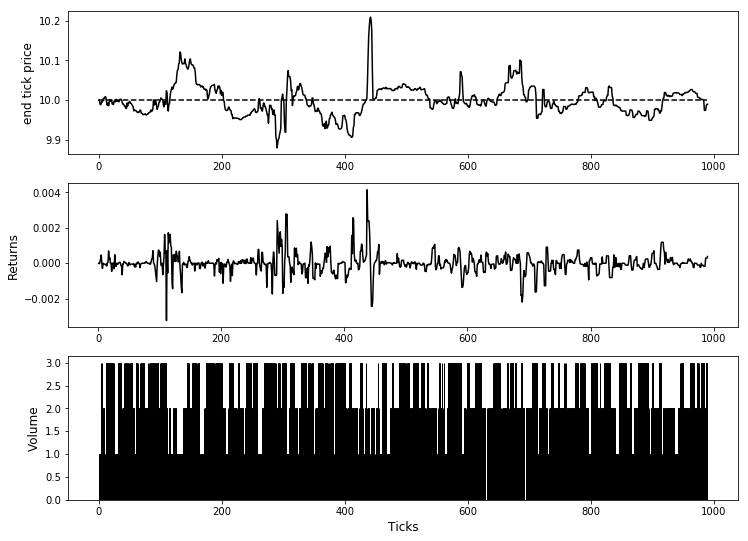

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
#ax1.legend()

ax2.plot(mc_returns.index, mc_returns.median(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(mc_volume.index, mc_volume.median(axis=1), color='k', edgecolor='k')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')

#fig.savefig('benchmark_baseline_dynamics.png')

### b HFM profitability

In [71]:
percentage_trades_hfm = [prcnt_hft_trading(ob) for ob in obs]
np.mean(percentage_trades_hfm)

0.57327771589753607

In [72]:
all_s = [all_sharpe(h) for h in hfms]
np.mean(all_s)

20.15744356401499

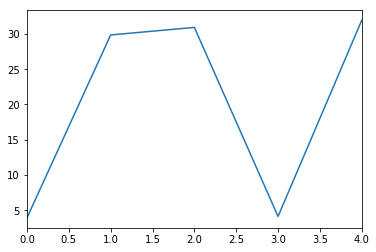

In [73]:
pd.Series(all_s).plot()

### c HFM quotes
Every tick, collect:
* bid-quote-price
* bid-quote-volume
* ask-quote-price
* ask-quote-volume

In [74]:
bid_quotes = [h[0].var_previous.bid_quote for h in hfms]
ask_quotes = [h[0].var_previous.ask_quote for h in hfms]
bid_volume = [h[0].var_previous.bid_quote_volume for h in hfms]
ask_volume = [h[0].var_previous.ask_quote_volume for h in hfms]

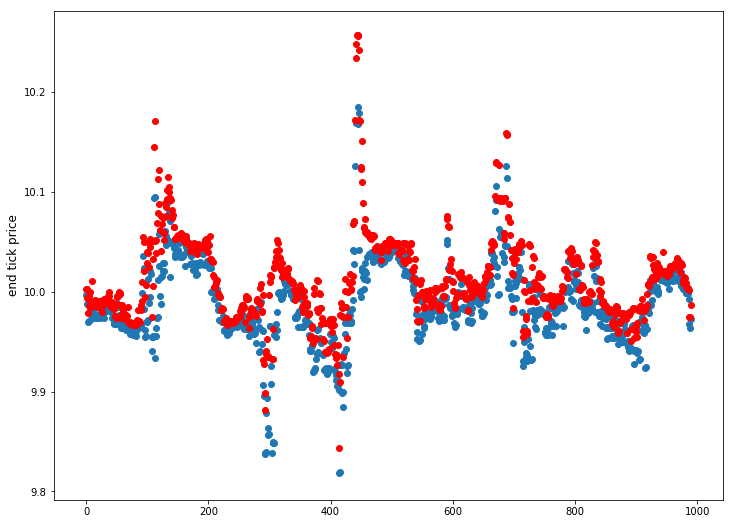

In [75]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

#ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
#ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')

ax1.scatter(pd.Series(bid_quotes[0]).index, pd.Series(bid_quotes[0]))
ax1.scatter(pd.Series(ask_quotes[0]).index, pd.Series(ask_quotes[0]), color='r')

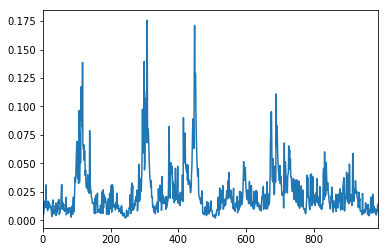

In [76]:
pd.Series(np.array(np.array(ask_quotes[0]) - bid_quotes[0])).plot()

In [77]:
bid_ask = bid_ask = [((ask - bid) / np.mean([ask, bid])) / 2 for bid, ask in zip(orderbook.highest_bid_price_history, orderbook.lowest_ask_price_history)]
bid_ask = list(filter(lambda x: x >0, bid_ask))

### HFM profitability

In [78]:
money = []
stocks = []
locked_in_profits = []
for hft in high_frequency_traders:
    money.append(np.array(hft.var_previous.money))
    stocks.append(np.array(hft.var_previous.stocks))
    locked_in_profits.append(np.array(hft.var_previous.locked_profit))

In [79]:
stocks_worth = stocks[0] * np.array(orderbook.tick_close_price)
wealth = stocks_worth + money[0]

In [80]:
#stocks[0] - np.ones
inventory_deviation_from_target = stocks[0] - (np.zeros(len(stocks[0])) + 10)

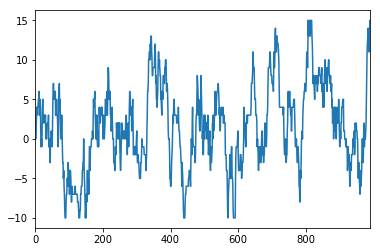

In [81]:
pd.Series(inventory_deviation_from_target).plot()

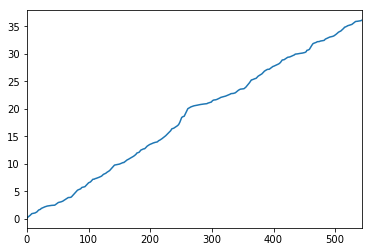

In [82]:
pd.Series(np.cumsum(locked_in_profits[0])).plot()

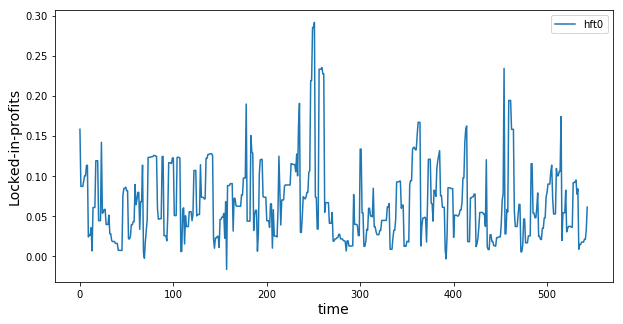

In [83]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, p in enumerate(locked_in_profits):
    ax1.plot(range(len(p)), p, label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Locked-in-profits', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

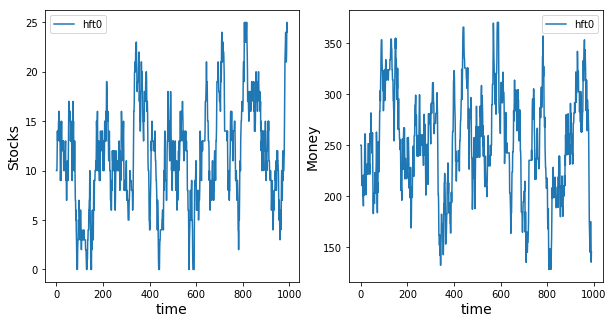

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

timeframe = 10000

for idx, s in enumerate(stocks):
    ax1.plot(range(len(s[:timeframe])), s[:timeframe], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Stocks', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

for idx, m in enumerate(money):
    ax2.plot(range(len(m[:timeframe])), m[:timeframe], label='hft{}'.format(idx))

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax2.set_ylabel('Money', fontsize='14')
ax2.set_xlabel('time', fontsize='14')

### Summary

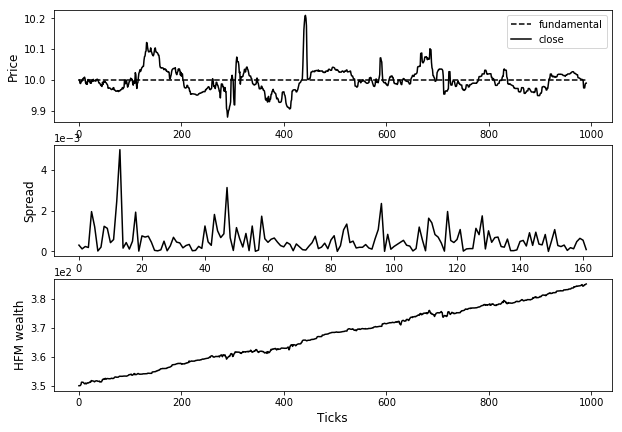

In [85]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,7))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental')
ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close')
ax1.set_ylabel('Price', fontsize='12')
ax1.legend()

ax2.plot(pd.Series(bid_ask).index, pd.Series(bid_ask), 'k-')
ax2.set_ylabel('Spread', fontsize='12')

ax3.plot(range(len(wealth)), wealth, 'k-')
ax3.set_ylabel('HFM wealth', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')


for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

fig.savefig('benchmark_baseline_dynamics.png')

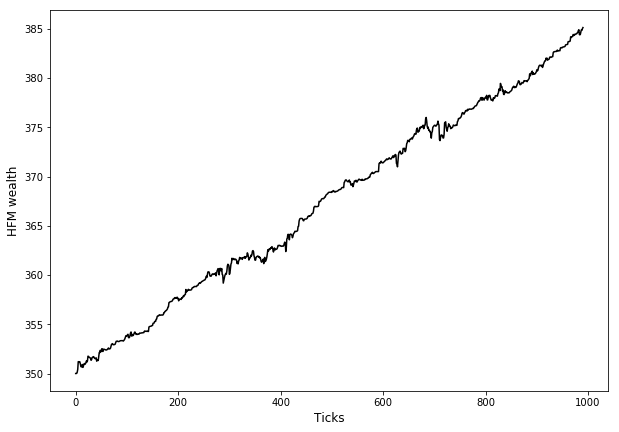

In [86]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,7))


ax1.plot(range(len(wealth)), wealth, 'k-')
ax1.set_ylabel('HFM wealth', fontsize='12')
ax1.set_xlabel('Ticks', fontsize='12')

fig.savefig('hfm_wealth.png')

### d Autocorrelation of returns

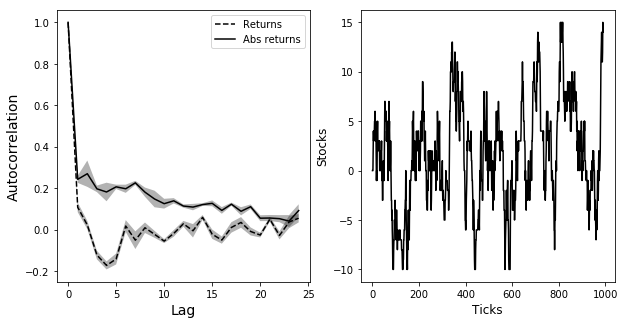

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax2.plot(range(len(inventory_deviation_from_target)), inventory_deviation_from_target, 'k-', label='deviation from target')
ax2.set_ylabel('Stocks', fontsize='12')
ax2.set_xlabel('Ticks', fontsize='12')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

fig.savefig('benchmark_stylized_facts.png')

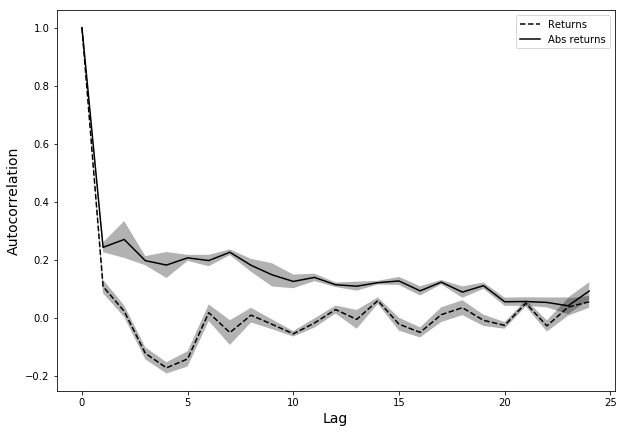

In [88]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,7))

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

fig.savefig('hfm_autocorrelation.png')

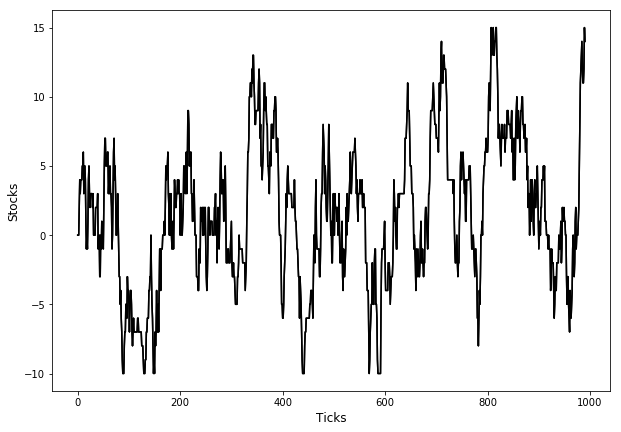

In [89]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,7))

ax1.plot(range(len(inventory_deviation_from_target)), inventory_deviation_from_target, 'k-', label='deviation from target')
ax1.set_ylabel('Stocks', fontsize='12')
ax1.set_xlabel('Ticks', fontsize='12')

ax1.plot(range(len(inventory_deviation_from_target)), inventory_deviation_from_target, 'k-', label='deviation from target')
ax1.set_ylabel('Stocks', fontsize='12')
ax1.set_xlabel('Ticks', fontsize='12')

fig.savefig('hfm_inventory.png')

## 2 Experiment no HFM vs HFM
Impact on: 
* spreads
* orderbook depth around the mid point.
* orderbook balance (increase)

In [94]:
parameters['n_hft'] = 0

In [95]:
hfms0 = []
lfts0 = []
obs0 = []
for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
    print('seed is ', seed)
    high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
    hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
    hfms0.append(hft)
    lfts0.append(lft)
    obs0.append(ob)

seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250


C:\Users\joerischasfoort\Documents\GitHub\hfm-abm\hft_model.py:21: RuntimeWarning: divide by zero encountered in true_divide
  adj_factor = np.divide(1., sum(all_speed))


tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750


### Spreads

In [96]:
def av_bid_asks(orderbooks):
    mean_bid_asks = []
    for ob in orderbooks:
        bid_ask = [ask - bid for bid, ask in zip(ob.highest_bid_price_history, ob.lowest_ask_price_history)]
        # quoted bid_ask_spread = (Ask - Bid / Mid) / 2
        bid_ask = list(filter(lambda x: x >0, bid_ask))
        mean_bid_asks.append(np.mean(bid_ask))
    return mean_bid_asks

In [99]:
av_bid_aks = [np.mean(av_bid_asks(obs0)), np.mean(av_bid_asks(obs))]

### Depth

In [106]:
def depth(orderbooks):
    average_depth = []
    average_imbalance = []
    for ob in orderbooks:
        av_ask_depth = np.mean(ob.tick_bid_depth) #[np.mean(prices) for prices in orderbook.transaction_prices_history]
        av_bid_depth = np.mean(ob.tick_ask_depth)
        average_imbalance.append(np.mean(abs(np.array(ob.tick_bid_depth) - np.array(ob.tick_ask_depth))))
        average_depth.append(av_ask_depth + av_bid_depth)
    return average_depth, average_imbalance

In [107]:
depths = [np.mean(depth(obs0)[0]), np.mean(depth(obs)[0])]
imbalance = [np.mean(depth(obs0)[1]), np.mean(depth(obs)[1])]

In [109]:
imbalance

[6.5997979797979793, 5.7979797979797976]

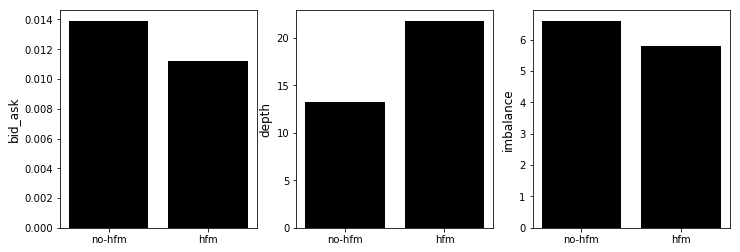

In [123]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.bar([0,1], av_bid_aks, color='k')
ax2.bar([0,1], depths, color='k')
ax3.bar([0,1], imbalance, color='k')

ax1.set_ylabel('bid_ask', fontsize='12')
ax2.set_ylabel('depth', fontsize='12')
ax3.set_ylabel('imbalance', fontsize='12')

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([0,1])
    ax.set_xticklabels(['no-hfm', 'hfm'])

fig.savefig('hfm_experiment.png')


## 3 Experiment increase HFM speed
Impact on:
* HFM profits 
* spreads? 

In [125]:
parameters['n_hft'] = 1

In [131]:
def vol(orderbooks):
    volume = []
    for ob in orderbooks:
        total_tick_volume = [sum(volumes) for volumes in ob.transaction_volumes_history]
        volume.append(sum(total_tick_volume))
    return volume

In [132]:
def vola(orderbooks):
    volatility = []
    for ob in orderbooks:
        end_tick_price = ob.tick_close_price #[np.mean(prices) for prices in orderbook.transaction_prices_history]
        returns = pd.Series(np.array(end_tick_price)).pct_change()
        volatility.append(returns.std())
    return volatility

In [129]:
hfms = []
lfts = []
obs = []
for tick_p_min in range(1, 20):
    parameters["ticks_per_minute"] = tick_p_min
    print('exp ', tick_p_min)
    hfms_seed = []
    lfts_seed = []
    obs_seed = []
    for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
        print('seed is ', seed)
        high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
        hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
        hfms_seed.append(hft)
        lfts_seed.append(lft)
        obs_seed.append(ob)
    
    hfms.append(hfms_seed)
    lfts.append(lfts_seed)
    obs.append(obs_seed)

exp  1
seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750
exp  2
seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750
exp  3
seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750
exp  4
seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750
exp  5
seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  7

In [133]:
average_bid_asks = [av_bid_asks(orderbooks) for orderbooks in obs]
volumes = [vol(orderbooks) for orderbooks in obs]
volatilities = [vola(orderbooks) for orderbooks in obs]
depths = [depth(orderbooks)[0] for orderbooks in obs]
imbalance = [depth(orderbooks)[1] for orderbooks in obs]

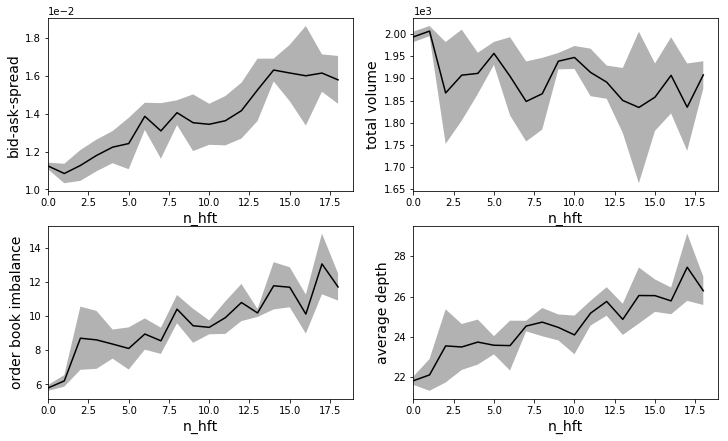

In [134]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

ax1.plot(range(len(average_bid_asks)), [np.mean(bid_asks) for bid_asks in average_bid_asks], c='k', label='Bid-ask')
ax1.fill_between(range(len(average_bid_asks)), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])+np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])-np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 alpha=0.3, facecolor='black')

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

ax2.plot(range(len(volumes)), [np.mean(volume) for volume in volumes], c='k')
ax2.fill_between(range(len(volumes)), 
                 np.array([np.mean(volume) for volume in volumes])+np.array([np.std(volume) for volume in volumes]), 
                 np.array([np.mean(volume) for volume in volumes])-np.array([np.std(volume) for volume in volumes]), 
                 alpha=0.3, facecolor='black')

ax2.set_ylabel('total volume', fontsize='14')
ax2.set_xlabel('n_hft', fontsize='14')
ax2.set_xlim(xmin=0)

ax3.plot(range(len(imbalance)), [np.mean(i) for i in imbalance], c='k')
ax3.fill_between(range(len(imbalance)), 
                 np.array([np.mean(i) for i in imbalance])+np.array([np.std(i) for i in imbalance]), 
                 np.array([np.mean(i) for i in imbalance])-np.array([np.std(i) for i in imbalance]), 
                 alpha=0.3, facecolor='black')
ax3.set_ylabel('order book imbalance', fontsize='14')
ax3.set_xlabel('n_hft', fontsize='14')
ax3.set_xlim(xmin=0)

ax4.plot(range(len(depths)), [np.mean(d) for d in depths], c='k')
ax4.fill_between(range(len(depths)), 
                 np.array([np.mean(d) for d in depths])+np.array([np.std(d) for d in depths]), 
                 np.array([np.mean(d) for d in depths])-np.array([np.std(d) for d in depths]), 
                 alpha=0.3, facecolor='black')

ax4.set_ylabel('average depth', fontsize='14')
ax4.set_xlabel('n_hft', fontsize='14')
ax4.set_xlim(xmin=0)

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('speed_predictions.png')